In [45]:
import numpy as np
from data_tools.query import SunbeamClient
from physics.models.motor import AdvancedMotor
from scipy import optimize
import matplotlib.pyplot as plt
import dill


In [48]:
client = SunbeamClient(api_url="localhost:8080")

try:
    velocity = client.get_file("main", "FSGP_2024_Day_1", "ingress", "VehicleVelocity").unwrap().data
    actual_power = client.get_file("main", "FSGP_2024_Day_1", "power", "MotorPower").unwrap().data
    trackIndex = client.get_file("main", "FSGP_2024_Day_1", "localization", "TrackIndex").unwrap().data
    
    with open("velocity.pkl", "wb") as f:
        dill.dump(velocity, f, protocol=dill.HIGHEST_PROTOCOL)
    
    with open("actual_power.pkl", "wb") as f:
        dill.dump(actual_power, f, protocol=dill.HIGHEST_PROTOCOL)
    
    with open("trackIndex.pkl", "wb") as f:
        dill.dump(trackIndex, f, protocol=dill.HIGHEST_PROTOCOL)

except Exception:
    with open("velocity.pkl", "rb") as f:
        velocity = dill.load(f)
    
    with open("actual_power.pkl", "rb") as f:
        actual_power = dill.load(f)
    
    with open("trackIndex.pkl", "rb") as f:
        trackIndex = dill.load(f)

In [49]:
from micro_strategy import MicroModelBuilder, load_configs

initial_conditions, environment_config, car_config = load_configs()

micro_builder = (
        MicroModelBuilder()
        .set_environment_config(
            environment_config,
            rebuild_weather_cache=False,
            rebuild_route_cache=False,
            rebuild_competition_cache=False,
        )
        .set_initial_conditions(initial_conditions)
        .set_car_config(car_config)
    )
micro_builder.compile()
_, gis = micro_builder.get()

motor_model = AdvancedMotor(
    vehicle_mass=350,
    road_friction = 0.012,
    tire_radius = 0.2032,
    vehicle_frontal_area = 1.1853,
    drag_coefficient = 0.11609
    
)

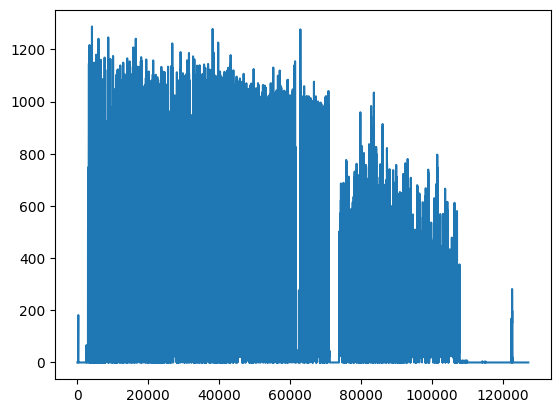

In [50]:
actual_energy = np.clip(actual_power * actual_power.period, a_min=0, a_max=None)

plt.plot(actual_energy)

In [33]:
p0 = [0.11609, 0.012, 50000, 1.0, 1.0]
bounds = ((0, 0, 10000, 0, 0), (100, 100, 100000, 1000, 100))

window = slice(10000, 41000, 1)

trackIndexCleaned = np.nan_to_num(trackIndex).astype(int)[window]
gradients = gis.get_gradients(trackIndexCleaned)
wind_speeds = np.zeros_like(gradients)
tick = trackIndex.period
coords = gis.get_path()[trackIndexCleaned]

def objective(x, drag, friction, cornering, inertial_coefficient, drag2):
    motor_model = AdvancedMotor(
        vehicle_mass=350,
        road_friction = friction,
        tire_radius = 0.2032,
        vehicle_frontal_area = 1.1853,
        drag_coefficient = drag,
        cornering_coefficient = cornering,
        inertial_force_coefficient = inertial_coefficient,
        drag2=drag2,
    )
    energy = motor_model.calculate_energy_in(x * 3.6, gradients, wind_speeds, tick, coords)
    
    return energy

popt, pcov = optimize.curve_fit(objective, velocity[window], actual_energy[window], p0, bounds=bounds)

404973.3848907672
404973.3848907672
404973.3848907672
404973.39092534094
404973.3848907672
404973.3848907672
336867.3481248126
336867.3481248126
336867.3481248126
336867.3531445273
336867.3481248126
336867.3481248126
184168.96638271678
184168.96638271678
184168.96638271678
184168.96912704824
184168.96638271678
184168.96638271678
120433.42005543
120433.42005543
120433.42005543
120433.42185002781
120433.42005543
120433.42005543
93036.6841494033
93036.6841494033
93036.6841494033
93036.6855357579
93036.6841494033
93036.6841494033
83609.06408951343
83609.06408951343
83609.06408951343
83609.06533538556
83609.06408951343
83609.06408951343
81436.60851094902
81436.60851094902
81436.60851094902
81436.60972444904
81436.60851094902
81436.60851094902
81049.14234519
81049.14234519
81049.14234519
81049.14355291636
81049.14234519
81049.14234519
81000.63328359801
80999.45272164271
81030.4811473198
81030.4811473198
81030.4811473198
81030.48235476807
81030.4811473198
81030.4811473198
81000.27121017744
81

In [34]:
popt

array([1.17007581e-07, 1.11645595e-03, 1.00000002e+04, 5.64135331e+00,
       1.49638004e-07])

In [40]:
predicted_energy = objective(velocity[window], *popt)

404973.39380836


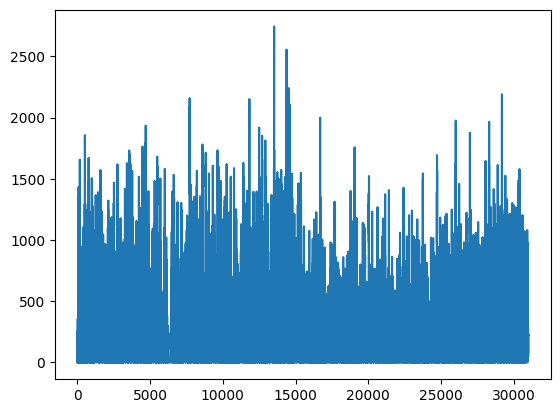

In [41]:
plt.plot(predicted_energy)

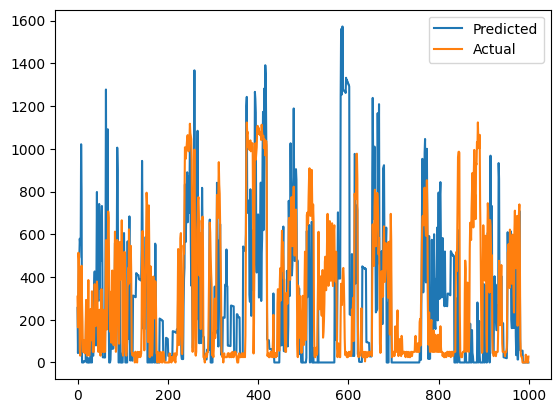

In [42]:
fig, ax = plt.subplots()

show_window = slice(1000, 2000, 1)

ax.plot(predicted_energy[show_window], label="Predicted")
ax.plot(actual_energy[window][show_window], label="Actual")
plt.legend()
plt.show()

In [43]:
total_predicted = np.trapezoid(predicted_energy, dx=actual_energy.period)
total_actual = np.trapezoid(actual_energy[window], dx=actual_energy.period)
print(f"Actual Energy: {total_actual / 1e6} MJ \n Predicted Energy: {total_predicted / 1e6} MJ")


Actual Energy: 1.8677311894243354 MJ 
 Predicted Energy: 1.4850564477620172 MJ
